# Star Wars Original Trilogy - Temporal Analysis

This notebook performs temporal analysis across the three Star Wars movies:
1. **Temporal Character Network**: Character connections per movie based on shared scenes
2. **Temporal Bipartite Network**: Character-Location connections per movie
3. **Temporal Sentiment Analysis**: How character sentiments evolve across the trilogy

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import io
import os
import requests
from pathlib import Path
from collections import defaultdict
from bs4 import BeautifulSoup

# Set up data directory
DATA_DIR = Path("data")

# Movie order for temporal analysis
MOVIES = ["A New Hope", "The Empire Strikes Back", "Return of the Jedi"]
MOVIE_COLORS = {
    "A New Hope": "#1f77b4",
    "The Empire Strikes Back": "#ff7f0e",
    "Return of the Jedi": "#2ca02c",
}

## Load Sentiment Data and Setup Helper Functions

In [38]:
# Load sentiment dataset
local_sentiment_data = "../data/Data_Set_S1.txt"
raw_sentiment_url = "https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/data/Data_Set_S1.txt"

if os.path.exists(local_sentiment_data):
    df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

df["word"] = df["word"].astype("string")

# Create word to happiness score mapping
word_to_happiness_avg = dict(zip(df["word"], df["happiness_average"]))


def sentiment_score(text: str):
    """Calculate average sentiment score for a text based on word happiness scores."""
    if not text:
        return None
    tokens_lower = text.lower().split()
    scores = [
        word_to_happiness_avg[token]
        for token in tokens_lower
        if token in word_to_happiness_avg
    ]
    if scores:
        return sum(scores) / len(scores)
    return None


print(f"Loaded sentiment dataset with {len(word_to_happiness_avg)} words")
print(
    f"Sentiment score range: {min(word_to_happiness_avg.values()):.2f} - {max(word_to_happiness_avg.values()):.2f}"
)

Loaded sentiment dataset with 10222 words
Sentiment score range: 1.30 - 8.50


In [39]:
# Character name normalization mapping
CHARACTER_NORMALIZATION = {
    # Luke
    "LUKE": "Luke Skywalker",
    "LUKE SKYWALKER": "Luke Skywalker",
    "LUKE'S VOICE": "Luke Skywalker",
    # Han Solo
    "HAN": "Han Solo",
    "HAN SOLO": "Han Solo",
    "HAN'S VOICE": "Han Solo",
    # Leia
    "LEIA": "Leia Organa",
    "LEIA ORGANA": "Leia Organa",
    "LEIA'S VOICE": "Leia Organa",
    "PRINCESS LEIA": "Leia Organa",
    "LEA": "Leia Organa",
    # Obi-Wan
    "OBI-WAN": "Obi-Wan Kenobi",
    "OBI WAN": "Obi-Wan Kenobi",
    "OBI-WAN KENOBI": "Obi-Wan Kenobi",
    "BEN": "Obi-Wan Kenobi",
    "OLD BEN": "Obi-Wan Kenobi",
    # Yoda
    "YODA": "Yoda",
    "YODA'S VOICE": "Yoda",
    # Darth Vader
    "VADER": "Darth Vader",
    "DARTH VADER": "Darth Vader",
    "LORD VADER": "Darth Vader",
    "VADER'S VOICE": "Darth Vader",
    # Emperor Palpatine
    "EMPEROR": "Emperor Palpatine",
    "PALPATINE": "Emperor Palpatine",
    "EMPEROR PALPATINE": "Emperor Palpatine",
    "THE EMPEROR": "Emperor Palpatine",
    "EMPEROR'S VOICE": "Emperor Palpatine",
    # Lando
    "LANDO": "Lando Calrissian",
    "LANDO CALRISSIAN": "Lando Calrissian",
    # Chewbacca
    "CHEWBACCA": "Chewbacca",
    "CHEWIE": "Chewbacca",
    "CHEW": "Chewbacca",
    # Droids
    "C-3PO": "C-3PO",
    "C3PO": "C-3PO",
    "THREEPIO": "C-3PO",
    "THREE-PO": "C-3PO",
    "R2-D2": "R2-D2",
    "R2D2": "R2-D2",
    "ARTOO": "R2-D2",
    # Other named characters
    "WEDGE": "Wedge Antilles",
    "WEDGE ANTILLES": "Wedge Antilles",
    "UNCLE OWEN": "Owen Lars",
    "OWEN": "Owen Lars",
    "AUNT BERU": "Beru Lars",
    "BERU": "Beru Lars",
    "BIGGS": "Biggs Darklighter",
    "BIGGS DARKLIGHTER": "Biggs Darklighter",
    "TARKIN": "Grand Moff Tarkin",
    "GRAND MOFF TARKIN": "Grand Moff Tarkin",
    "MOFF TARKIN": "Grand Moff Tarkin",
}

# Location normalization mapping
LOCATION_NORMALIZATION = {
    "Darth Vader's Star Destroyer": "Vader's Star Destroyer",
    "Imperial Stardestroyer": "Imperial Star Destroyer",
    "Luke's X-Wing Fighter": "Luke's X-Wing",
    "Main Hangar Deck": "Main Hangar",
    "Red Ten's Cockpit.": "Red Ten's Cockpit",
    "Sail Barge Observation Deck": "Sail Barge",
    "Snowspeeder Cockpit": "Snowspeeder",
    "Stolen Imperial Shuttle": "Imperial Shuttle",
    "Tatooine Sea": "Tatooine",
    "Red Leader's X-Wing": "Red Leader Starship",
    "Red Leader's Cockpit": "Red Leader Starship",
    "Red Leader's Fighter": "Red Leader Starship",
}


def normalize_character_name(name):
    """Normalize a character name to canonical form."""
    if not name or not isinstance(name, str):
        return None
    name_upper = name.upper().strip()
    name_upper = re.sub(r"\s*\(V\.O\.\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*\(CONT\'D\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*O\.S\.\s*$", "", name_upper)

    if name_upper in CHARACTER_NORMALIZATION:
        return CHARACTER_NORMALIZATION[name_upper]
    if (
        name_upper
        and len(name_upper) > 2
        and name_upper not in ["THE", "AND", "OR", "TO"]
    ):
        return name_upper.title()
    return None


def clean_location_name(location):
    """Clean and normalize location names from scene headings."""
    if not location:
        return None
    location = re.sub(r"^[0-9]+\s+", "", location).strip()
    location = re.sub(r"^(INT|EXT)[\.\s]+", "", location, flags=re.IGNORECASE).strip()
    location = re.sub(
        r"\s+[--]\s+(DAY|NIGHT|DAWN|DUSK|CONTINUOUS)$",
        "",
        location,
        flags=re.IGNORECASE,
    )
    location = re.sub(r"\s*\([^)]*\)\s*$", "", location)
    if " - " in location or " – " in location:
        location = re.split(r"\s+[-–]\s+", location)[0]
    location = re.sub(r"\s+", " ", location).strip()
    location = location.title()
    location = re.sub(r"'S\b", "'s", location)
    if location in LOCATION_NORMALIZATION:
        location = LOCATION_NORMALIZATION[location]
    return location if location else None


print("Character and location normalization functions loaded.")

Character and location normalization functions loaded.


## Parse Scripts and Extract Scenes Per Movie

In [40]:
def extract_scenes_and_dialogues(html_content):
    """Extract scenes with characters and their dialogues from script HTML."""
    soup = BeautifulSoup(html_content, "html.parser")
    script_table = soup.find("td", class_="scrtext")
    if not script_table:
        return []

    pre_tag = script_table.find("pre")
    if not pre_tag:
        return []

    script_text = pre_tag.get_text()
    lines = script_text.split("\n")

    scenes = []
    current_scene = {
        "location": None,
        "characters": set(),
        "dialogues": defaultdict(list),
    }
    current_speaking_character = None
    scene_started = False

    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue

        # Detect scene headings
        is_scene_heading = False
        if re.match(r"^[0-9]+\s+[A-Z]", line_stripped):
            is_scene_heading = True
            scene_started = True
        elif re.match(r"^(INT|EXT)\.\s+", line_stripped):
            is_scene_heading = True
            scene_started = True

        if is_scene_heading:
            if current_scene["location"] is not None:
                scenes.append(current_scene)
            current_scene = {
                "location": line_stripped,
                "characters": set(),
                "dialogues": defaultdict(list),
            }
            current_speaking_character = None

        # Detect character names (all caps)
        elif (
            scene_started
            and re.match(r"^[A-Z][A-Z\s\-\']*$", line_stripped)
            and len(line_stripped) > 1
            and len(line_stripped) < 50
        ):
            char_name = line_stripped.strip()
            skip_names = [
                "FADE IN:",
                "FADE OUT:",
                "THE END",
                "CREDITS",
                "TO BE CONTINUED",
                "CUT TO:",
                "DISSOLVE TO:",
                "CONTINUED:",
            ]
            if char_name and char_name not in skip_names:
                current_speaking_character = char_name
                current_scene["characters"].add(char_name)

        # Handle dialogue lines
        elif scene_started and current_speaking_character:
            # Skip stage directions in parentheses
            if not (line_stripped.startswith("(") and line_stripped.endswith(")")):
                current_scene["dialogues"][current_speaking_character].append(
                    line_stripped
                )

    if current_scene["location"] is not None:
        scenes.append(current_scene)

    return scenes


# Load and parse all scripts
scripts = {}
all_scenes_per_movie = {}

for movie in MOVIES:
    script_file = DATA_DIR / f"html/Star-Wars-{movie.replace(' ', '-')}.html"
    with open(script_file, "r", encoding="utf-8", errors="replace") as f:
        scripts[movie] = f.read()

    scenes = extract_scenes_and_dialogues(scripts[movie])
    all_scenes_per_movie[movie] = scenes
    print(f"{movie}: {len(scenes)} scenes extracted")

A New Hope: 479 scenes extracted
The Empire Strikes Back: 277 scenes extracted
Return of the Jedi: 137 scenes extracted


In [41]:
# Build per-movie data structures
character_connections_per_movie = {
    movie: defaultdict(lambda: defaultdict(int)) for movie in MOVIES
}
location_characters_per_movie = {movie: defaultdict(set) for movie in MOVIES}
character_dialogues_per_movie = {movie: defaultdict(list) for movie in MOVIES}

for movie, scenes in all_scenes_per_movie.items():
    for scene in scenes:
        location = clean_location_name(scene["location"])
        if not location:
            continue

        # Normalize character names
        normalized_chars = set()
        char_mapping = {}  # original -> normalized
        for char in scene["characters"]:
            normalized = normalize_character_name(char)
            if normalized:
                normalized_chars.add(normalized)
                char_mapping[char] = normalized

        if len(normalized_chars) == 0:
            continue

        # Add dialogues for each character
        for orig_char, dialogues in scene["dialogues"].items():
            normalized = char_mapping.get(orig_char)
            if normalized:
                character_dialogues_per_movie[movie][normalized].extend(dialogues)

        # Add characters to location
        for char in normalized_chars:
            location_characters_per_movie[movie][location].add(char)

        # Create character-to-character connections (if 2+ characters in scene)
        if len(normalized_chars) >= 2:
            char_list = list(normalized_chars)
            for i in range(len(char_list)):
                for j in range(i + 1, len(char_list)):
                    char1, char2 = char_list[i], char_list[j]
                    character_connections_per_movie[movie][char1][char2] += 1
                    character_connections_per_movie[movie][char2][char1] += 1

# Summary
for movie in MOVIES:
    n_chars = len(character_connections_per_movie[movie])
    n_locs = len(location_characters_per_movie[movie])
    n_dialogue_chars = len(character_dialogues_per_movie[movie])
    print(
        f"{movie}: {n_chars} characters in network, {n_locs} locations, {n_dialogue_chars} characters with dialogue"
    )

A New Hope: 60 characters in network, 37 locations, 69 characters with dialogue
The Empire Strikes Back: 49 characters in network, 27 locations, 50 characters with dialogue
Return of the Jedi: 41 characters in network, 42 locations, 42 characters with dialogue


## Task 1: Temporal Character Network Visualization
Create and visualize character-character networks for each movie, where edges represent shared scenes.

In [42]:
# Create character networks per movie
character_networks = {}

for movie in MOVIES:
    G = nx.Graph()
    connections = character_connections_per_movie[movie]

    for char, conns in connections.items():
        G.add_node(char)
        for other_char, weight in conns.items():
            if char < other_char:  # Avoid duplicates
                G.add_edge(char, other_char, weight=weight)

    character_networks[movie] = G
    print(
        f"{movie}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges, density: {nx.density(G):.4f}"
    )

A New Hope: 60 nodes, 153 edges, density: 0.0864
The Empire Strikes Back: 49 nodes, 108 edges, density: 0.0918
Return of the Jedi: 41 nodes, 98 edges, density: 0.1195


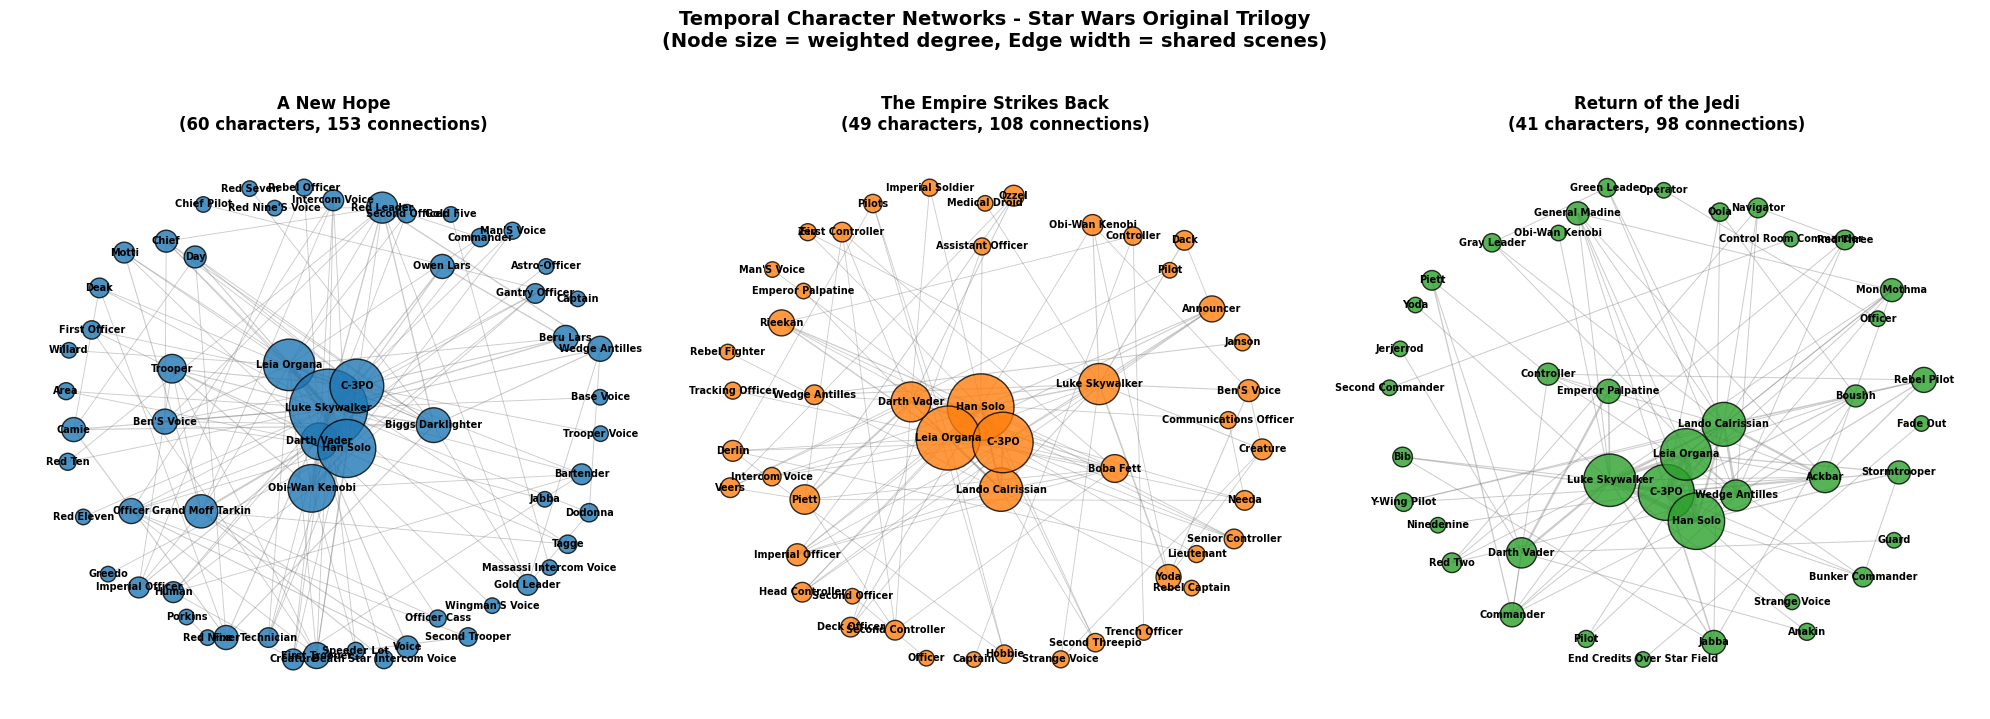

In [43]:
# Visualize temporal character networks (3 subplots)
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, movie in enumerate(MOVIES):
    ax = axes[idx]
    G = character_networks[movie]

    if G.number_of_nodes() == 0:
        ax.set_title(f"{movie}\n(No data)")
        ax.axis("off")
        continue

    # Use spring layout with seed for reproducibility
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42, weight="weight")

    # Node sizes based on weighted degree
    node_sizes = [G.degree(node, weight="weight") * 25 + 100 for node in G.nodes()]

    # Edge widths based on weight
    edges = G.edges()
    weights = [G[u][v]["weight"] for u, v in edges]
    max_weight = max(weights) if weights else 1
    edge_widths = [w / max_weight * 4 + 0.5 for w in weights]

    # Draw network
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=MOVIE_COLORS[movie],
        edgecolors="black",
        linewidths=1,
        ax=ax,
        alpha=0.8,
    )
    nx.draw_networkx_edges(
        G, pos, width=edge_widths, alpha=0.4, edge_color="gray", ax=ax
    )
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight="bold", ax=ax)

    ax.set_title(
        f"{movie}\n({G.number_of_nodes()} characters, {G.number_of_edges()} connections)",
        fontsize=12,
        fontweight="bold",
    )
    ax.axis("off")

plt.suptitle(
    "Temporal Character Networks - Star Wars Original Trilogy\n(Node size = weighted degree, Edge width = shared scenes)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

## Task 2: Temporal Bipartite Network Visualization
Create and visualize character-location bipartite networks for each movie.

In [26]:
# Create bipartite networks per movie
bipartite_networks = {}

for movie in MOVIES:
    G = nx.Graph()
    location_chars = location_characters_per_movie[movie]

    character_nodes = set()
    location_nodes = set()

    for location, characters in location_chars.items():
        G.add_node(location, node_type="location")
        location_nodes.add(location)

        for char in characters:
            if char not in character_nodes:
                G.add_node(char, node_type="character")
                character_nodes.add(char)
            G.add_edge(char, location, weight=1)

    bipartite_networks[movie] = {
        "graph": G,
        "characters": character_nodes,
        "locations": location_nodes,
    }
    print(
        f"{movie}: {len(character_nodes)} characters, {len(location_nodes)} locations, {G.number_of_edges()} edges"
    )

A New Hope: 70 characters, 37 locations, 155 edges
The Empire Strikes Back: 52 characters, 27 locations, 104 edges
Return of the Jedi: 44 characters, 42 locations, 143 edges


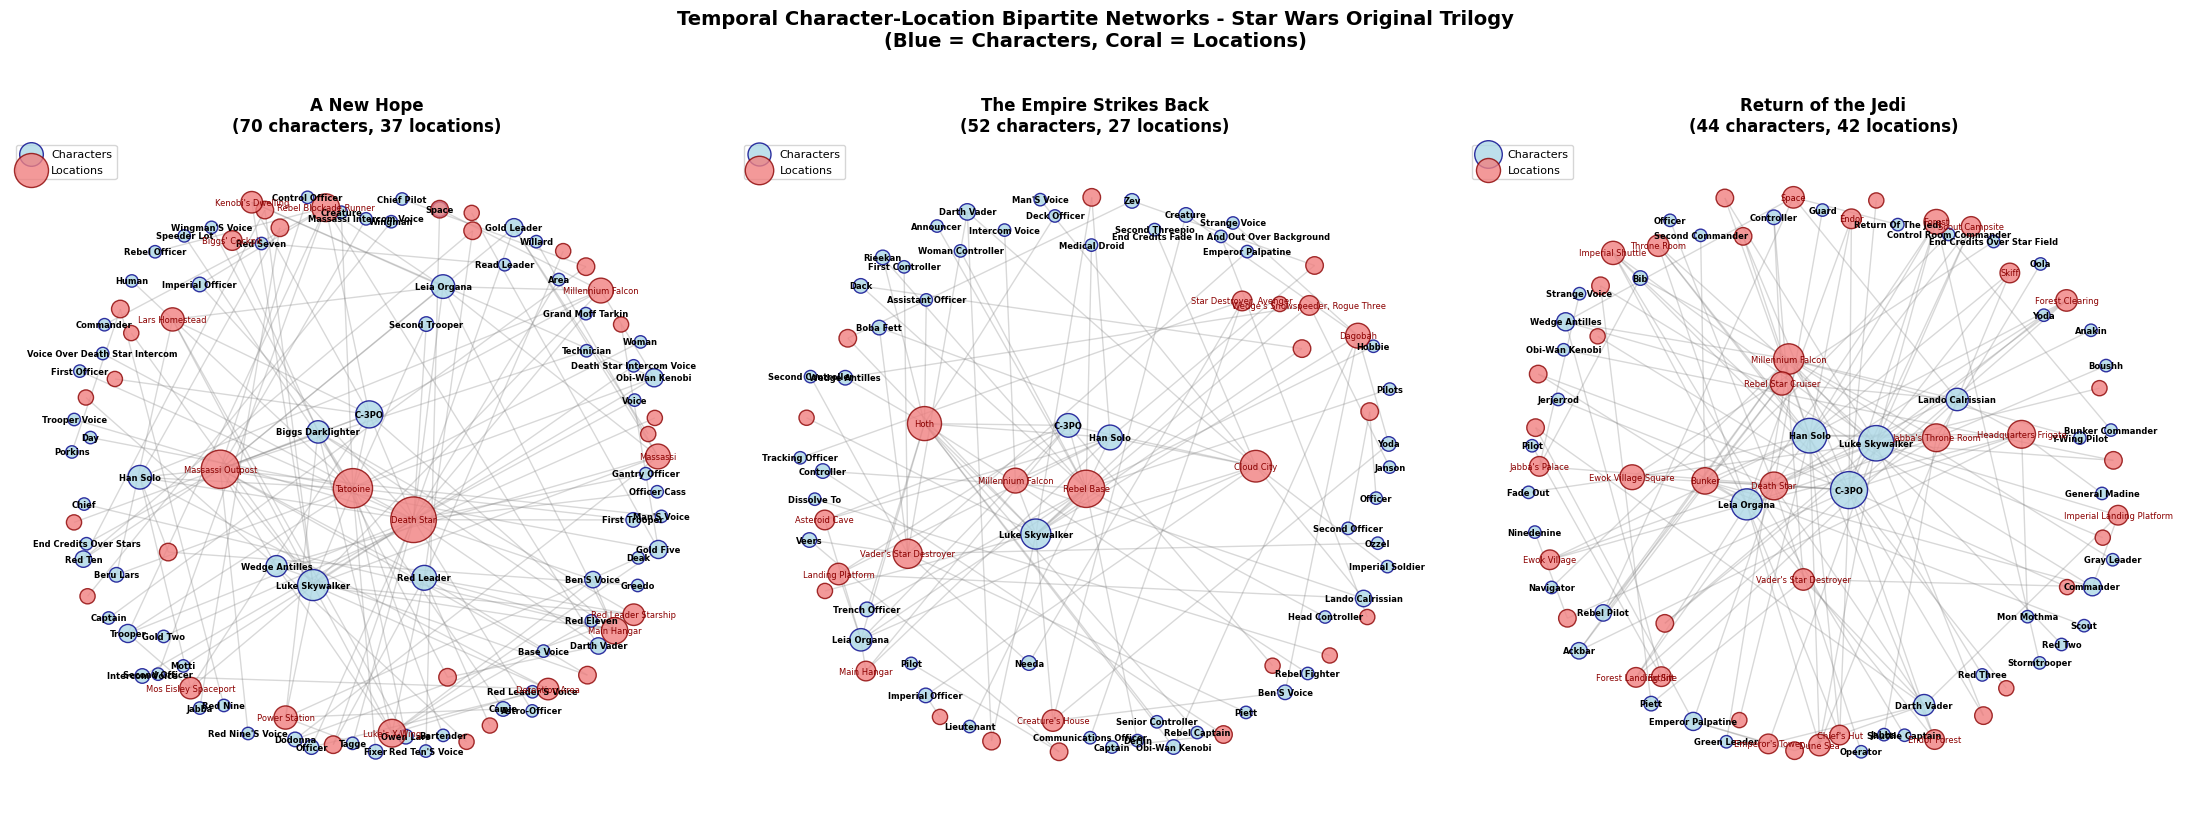

In [27]:
# Visualize temporal bipartite networks (3 subplots)
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

for idx, movie in enumerate(MOVIES):
    ax = axes[idx]
    data = bipartite_networks[movie]
    G = data["graph"]
    char_nodes = list(data["characters"])
    loc_nodes = list(data["locations"])

    if G.number_of_nodes() == 0:
        ax.set_title(f"{movie}\n(No data)")
        ax.axis("off")
        continue

    # Use spring layout
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

    # Node sizes based on degree
    char_sizes = [G.degree(node) * 30 + 50 for node in char_nodes]
    loc_sizes = [G.degree(node) * 40 + 80 for node in loc_nodes]

    # Draw character nodes (blue)
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=char_nodes,
        node_size=char_sizes,
        node_color="lightblue",
        edgecolors="darkblue",
        linewidths=1,
        ax=ax,
        alpha=0.8,
        label="Characters",
    )

    # Draw location nodes (coral)
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=loc_nodes,
        node_size=loc_sizes,
        node_color="lightcoral",
        edgecolors="darkred",
        linewidths=1,
        ax=ax,
        alpha=0.8,
        label="Locations",
    )

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray", ax=ax)

    # Draw labels for characters
    nx.draw_networkx_labels(
        G,
        pos,
        labels={n: n for n in char_nodes},
        font_size=6,
        font_weight="bold",
        ax=ax,
    )

    # Draw labels only for high-degree locations (to reduce clutter)
    high_degree_locs = {loc: loc for loc in loc_nodes if G.degree(loc) >= 3}
    if high_degree_locs:
        nx.draw_networkx_labels(
            G, pos, labels=high_degree_locs, font_size=6, font_color="darkred", ax=ax
        )

    ax.set_title(
        f"{movie}\n({len(char_nodes)} characters, {len(loc_nodes)} locations)",
        fontsize=12,
        fontweight="bold",
    )
    ax.legend(loc="upper left", fontsize=8)
    ax.axis("off")

plt.suptitle(
    "Temporal Character-Location Bipartite Networks - Star Wars Original Trilogy\n(Blue = Characters, Coral = Locations)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

## Task 3: Temporal Sentiment Analysis
Calculate sentiment scores for each character per movie and visualize the evolution across the trilogy.

In [28]:
# Calculate sentiment scores per character per movie
character_sentiments_per_movie = {movie: {} for movie in MOVIES}

for movie in MOVIES:
    dialogues = character_dialogues_per_movie[movie]
    for char, lines in dialogues.items():
        full_text = " ".join(lines)
        score = sentiment_score(full_text)
        character_sentiments_per_movie[movie][char] = score

# Summary of sentiments per movie
for movie in MOVIES:
    sentiments = character_sentiments_per_movie[movie]
    valid_scores = [s for s in sentiments.values() if s is not None]
    if valid_scores:
        print(f"\n{movie}:")
        print(f"  Characters with sentiment: {len(valid_scores)}")
        print(f"  Mean sentiment: {np.mean(valid_scores):.4f}")
        print(f"  Min: {min(valid_scores):.4f}, Max: {max(valid_scores):.4f}")


A New Hope:
  Characters with sentiment: 68
  Mean sentiment: 5.2877
  Min: 3.5400, Max: 5.9133

The Empire Strikes Back:
  Characters with sentiment: 47
  Mean sentiment: 5.3879
  Min: 4.8100, Max: 6.2800

Return of the Jedi:
  Characters with sentiment: 41
  Mean sentiment: 5.3453
  Min: 4.8250, Max: 6.1733


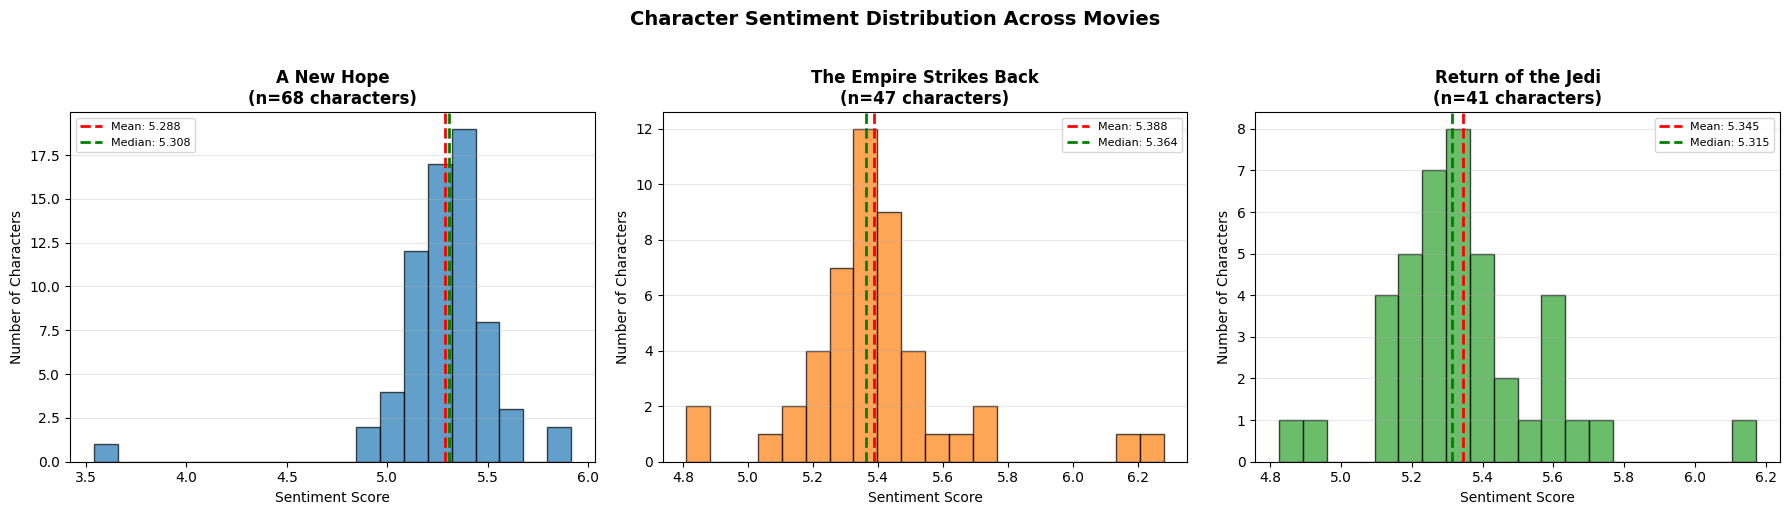

In [29]:
# Visualize sentiment distribution per movie (3 subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, movie in enumerate(MOVIES):
    ax = axes[idx]
    sentiments = character_sentiments_per_movie[movie]
    valid_scores = [s for s in sentiments.values() if s is not None]

    if not valid_scores:
        ax.set_title(f"{movie}\n(No sentiment data)")
        continue

    mean_val = np.mean(valid_scores)
    median_val = np.median(valid_scores)

    # Histogram
    ax.hist(
        valid_scores, bins=20, color=MOVIE_COLORS[movie], edgecolor="black", alpha=0.7
    )
    ax.axvline(
        mean_val,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_val:.3f}",
    )
    ax.axvline(
        median_val,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Median: {median_val:.3f}",
    )

    ax.set_xlabel("Sentiment Score", fontsize=10)
    ax.set_ylabel("Number of Characters", fontsize=10)
    ax.set_title(
        f"{movie}\n(n={len(valid_scores)} characters)", fontsize=12, fontweight="bold"
    )
    ax.legend(fontsize=8)
    ax.grid(axis="y", alpha=0.3)

plt.suptitle(
    "Character Sentiment Distribution Across Movies",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

### Characters with Biggest Sentiment Changes
Only including characters that appear in ALL 3 movies (have valid sentiment scores in each).

In [30]:
# Find characters that appear in ALL 3 movies with valid sentiment scores
characters_in_all_movies = []

# Get all unique characters across all movies
all_chars = set()
for movie in MOVIES:
    all_chars.update(character_sentiments_per_movie[movie].keys())

# Filter to only those with valid sentiment in all 3 movies
for char in all_chars:
    sentiments = []
    for movie in MOVIES:
        score = character_sentiments_per_movie[movie].get(char)
        if score is not None:
            sentiments.append(score)
        else:
            break
    if len(sentiments) == 3:
        characters_in_all_movies.append(char)

print(
    f"Characters appearing in all 3 movies with valid sentiment: {len(characters_in_all_movies)}"
)
print(f"Characters: {sorted(characters_in_all_movies)}")

Characters appearing in all 3 movies with valid sentiment: 8
Characters: ['C-3PO', 'Darth Vader', 'Han Solo', 'Leia Organa', 'Luke Skywalker', 'Obi-Wan Kenobi', 'Officer', 'Wedge Antilles']


In [31]:
# Calculate sentiment changes for characters in all 3 movies
sentiment_changes = []

for char in characters_in_all_movies:
    sentiments = [character_sentiments_per_movie[movie][char] for movie in MOVIES]

    # Calculate total change (first movie to last movie)
    total_change = sentiments[2] - sentiments[0]

    # Calculate max swing (highest - lowest across all movies)
    max_swing = max(sentiments) - min(sentiments)

    sentiment_changes.append(
        {
            "character": char,
            "A New Hope": sentiments[0],
            "The Empire Strikes Back": sentiments[1],
            "Return of the Jedi": sentiments[2],
            "total_change": total_change,
            "max_swing": max_swing,
        }
    )

# Create DataFrame and sort by max swing (absolute change)
df_changes = pd.DataFrame(sentiment_changes)
df_changes = df_changes.sort_values("max_swing", ascending=False)

print("Top 10 Characters with Biggest Sentiment Changes (sorted by max swing):\n")
print(df_changes.head(10).to_string(index=False))

Top 10 Characters with Biggest Sentiment Changes (sorted by max swing):

     character  A New Hope  The Empire Strikes Back  Return of the Jedi  total_change  max_swing
       Officer    5.308662                 6.280000            5.413333      0.104671   0.971338
Wedge Antilles    5.366491                 5.498684            5.241831     -0.124660   0.256853
Obi-Wan Kenobi    5.294730                 5.198286            5.390017      0.095287   0.191732
   Darth Vader    5.255503                 5.277236            5.352449      0.096947   0.096947
   Leia Organa    5.322644                 5.377121            5.291802     -0.030842   0.085319
      Han Solo    5.298779                 5.316504            5.290024     -0.008755   0.026480
Luke Skywalker    5.330154                 5.307518            5.318274     -0.011880   0.022636
         C-3PO    5.308068                 5.296243            5.290890     -0.017178   0.017178


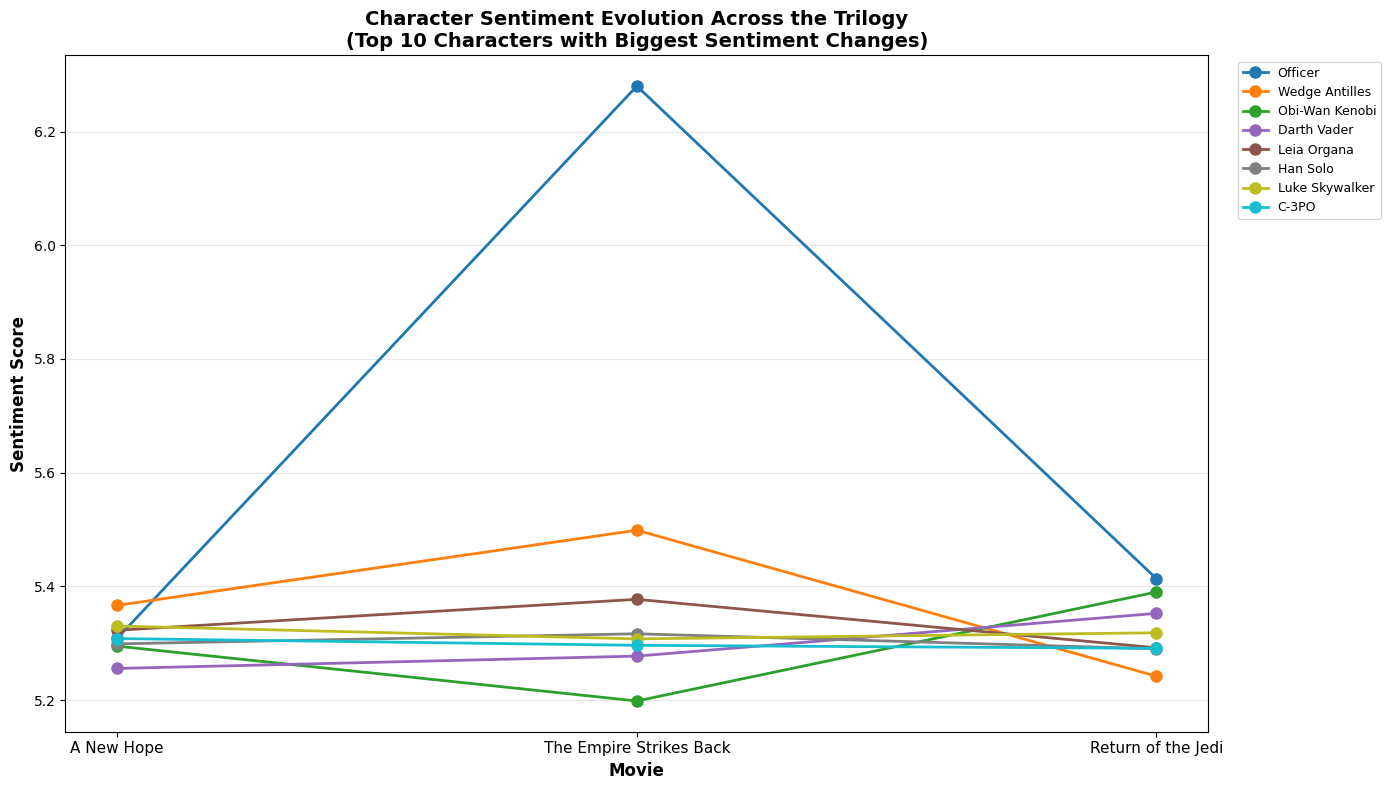

In [32]:
# Visualize sentiment evolution for characters with biggest changes
# Take top 10 characters by max swing
top_changing_chars = df_changes.head(10)["character"].tolist()

fig, ax = plt.subplots(figsize=(14, 8))

x_positions = np.arange(len(MOVIES))
colors = plt.cm.tab10(np.linspace(0, 1, len(top_changing_chars)))

for i, char in enumerate(top_changing_chars):
    sentiments = [character_sentiments_per_movie[movie][char] for movie in MOVIES]
    ax.plot(
        x_positions,
        sentiments,
        marker="o",
        linewidth=2,
        markersize=8,
        label=char,
        color=colors[i],
    )

ax.set_xticks(x_positions)
ax.set_xticklabels(MOVIES, fontsize=11)
ax.set_xlabel("Movie", fontsize=12, fontweight="bold")
ax.set_ylabel("Sentiment Score", fontsize=12, fontweight="bold")
ax.set_title(
    "Character Sentiment Evolution Across the Trilogy\n(Top 10 Characters with Biggest Sentiment Changes)",
    fontsize=14,
    fontweight="bold",
)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

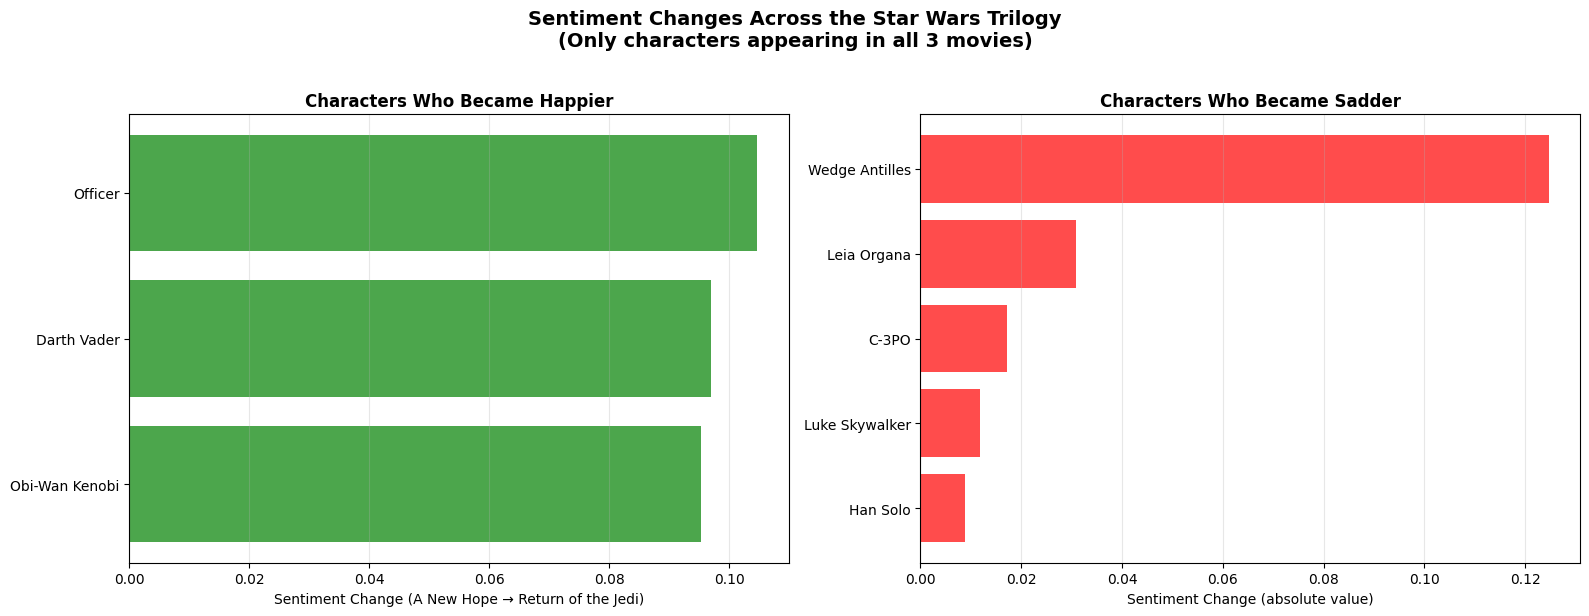

In [33]:
# Bar chart visualization: Sentiment change from first to last movie
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by total change for the bar charts
df_sorted_positive = df_changes.sort_values("total_change", ascending=False)
df_sorted_negative = df_changes.sort_values("total_change", ascending=True)

# Characters that became happier (positive change)
ax1 = axes[0]
positive_chars = df_sorted_positive[df_sorted_positive["total_change"] > 0].head(10)
if len(positive_chars) > 0:
    bars1 = ax1.barh(
        positive_chars["character"],
        positive_chars["total_change"],
        color="green",
        alpha=0.7,
    )
    ax1.set_xlabel("Sentiment Change (A New Hope → Return of the Jedi)", fontsize=10)
    ax1.set_title("Characters Who Became Happier", fontsize=12, fontweight="bold")
    ax1.invert_yaxis()
    ax1.grid(axis="x", alpha=0.3)
else:
    ax1.text(
        0.5,
        0.5,
        "No characters with positive change",
        ha="center",
        va="center",
        transform=ax1.transAxes,
    )
    ax1.set_title("Characters Who Became Happier", fontsize=12, fontweight="bold")

# Characters that became sadder (negative change)
ax2 = axes[1]
negative_chars = df_sorted_negative[df_sorted_negative["total_change"] < 0].head(10)
if len(negative_chars) > 0:
    bars2 = ax2.barh(
        negative_chars["character"],
        negative_chars["total_change"].abs(),
        color="red",
        alpha=0.7,
    )
    ax2.set_xlabel("Sentiment Change (absolute value)", fontsize=10)
    ax2.set_title("Characters Who Became Sadder", fontsize=12, fontweight="bold")
    ax2.invert_yaxis()
    ax2.grid(axis="x", alpha=0.3)
else:
    ax2.text(
        0.5,
        0.5,
        "No characters with negative change",
        ha="center",
        va="center",
        transform=ax2.transAxes,
    )
    ax2.set_title("Characters Who Became Sadder", fontsize=12, fontweight="bold")

plt.suptitle(
    "Sentiment Changes Across the Star Wars Trilogy\n(Only characters appearing in all 3 movies)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

### Main Characters Sentiment Evolution
Focus on the core main characters to see their emotional arcs.

In [ ]:
# Focus on main characters that appear in all 3 movies
main_characters = [
    "Luke Skywalker",
    "Han Solo",
    "Leia Organa",
    "Darth Vader",
    "C-3PO",
    "R2-D2",
    "Chewbacca",
    "Obi-Wan Kenobi",
    "Yoda",
    "Lando Calrissian",
]

# Filter to those actually in all 3 movies
main_chars_in_all = [c for c in main_characters if c in characters_in_all_movies]

print(f"Main characters appearing in all 3 movies: {main_chars_in_all}")
print("\nSentiment scores per movie:")

for char in main_chars_in_all:
    scores = [f"{character_sentiments_per_movie[movie][char]:.3f}" for movie in MOVIES]
    change = (
        character_sentiments_per_movie[MOVIES[2]][char]
        - character_sentiments_per_movie[MOVIES[0]][char]
    )
    direction = "↑" if change > 0 else "↓" if change < 0 else "→"
    print(
        f"  {char:20s}: {scores[0]} → {scores[1]} → {scores[2]}  ({direction} {abs(change):.3f})"
    )

Main characters appearing in all 3 movies: ['Luke Skywalker', 'Han Solo', 'Leia Organa', 'Darth Vader', 'C-3PO', 'Obi-Wan Kenobi']

Sentiment scores per movie:
  Luke Skywalker      : 5.330 → 5.308 → 5.318  (↓ 0.012)
  Han Solo            : 5.299 → 5.317 → 5.290  (↓ 0.009)
  Leia Organa         : 5.323 → 5.377 → 5.292  (↓ 0.031)
  Darth Vader         : 5.256 → 5.277 → 5.352  (↑ 0.097)
  C-3PO               : 5.308 → 5.296 → 5.291  (↓ 0.017)
  Obi-Wan Kenobi      : 5.295 → 5.198 → 5.390  (↑ 0.095)


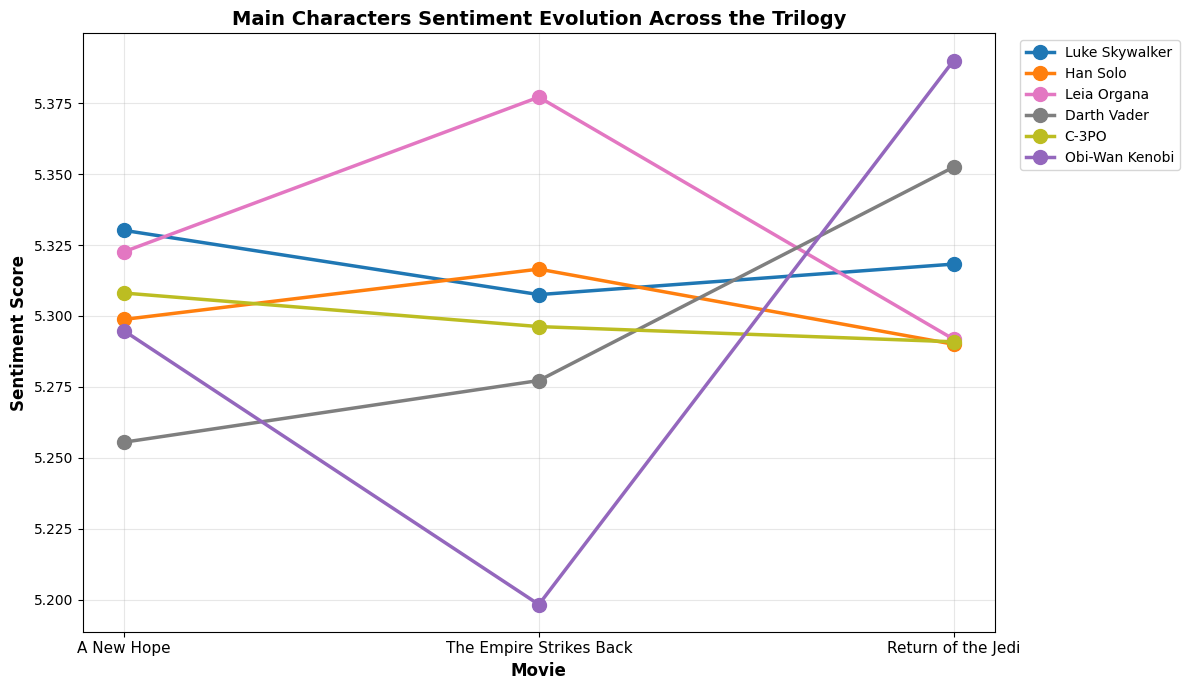

In [35]:
# Visualize main characters sentiment evolution
if main_chars_in_all:
    fig, ax = plt.subplots(figsize=(12, 7))

    x_positions = np.arange(len(MOVIES))

    # Use a distinct color palette for main characters
    main_char_colors = {
        "Luke Skywalker": "#1f77b4",  # Blue
        "Han Solo": "#ff7f0e",  # Orange
        "Leia Organa": "#e377c2",  # Pink
        "Darth Vader": "#7f7f7f",  # Gray
        "C-3PO": "#bcbd22",  # Yellow-green
        "R2-D2": "#17becf",  # Cyan
        "Chewbacca": "#8c564b",  # Brown
        "Obi-Wan Kenobi": "#9467bd",  # Purple
        "Yoda": "#2ca02c",  # Green
        "Lando Calrissian": "#d62728",  # Red
    }

    for char in main_chars_in_all:
        sentiments = [character_sentiments_per_movie[movie][char] for movie in MOVIES]
        color = main_char_colors.get(char, "black")
        ax.plot(
            x_positions,
            sentiments,
            marker="o",
            linewidth=2.5,
            markersize=10,
            label=char,
            color=color,
        )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(MOVIES, fontsize=11)
    ax.set_xlabel("Movie", fontsize=12, fontweight="bold")
    ax.set_ylabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_title(
        "Main Characters Sentiment Evolution Across the Trilogy",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)
    ax.grid(axis="both", alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No main characters found in all 3 movies with valid sentiment scores.")

## Summary Statistics

In [ ]:
# Print comprehensive summary
print("=" * 70)
print("TEMPORAL ANALYSIS SUMMARY - STAR WARS ORIGINAL TRILOGY")
print("=" * 70)

print("\n📊 CHARACTER NETWORK STATISTICS (per movie):")
for movie in MOVIES:
    G = character_networks[movie]
    print(f"\n  {movie}:")
    print(f"    Nodes (characters): {G.number_of_nodes()}")
    print(f"    Edges (connections): {G.number_of_edges()}")
    print(f"    Network density: {nx.density(G):.4f}")
    if G.number_of_nodes() > 0:
        degrees = dict(G.degree(weight="weight"))
        top_char = max(degrees, key=degrees.get)
        print(
            f"    Most connected: {top_char} ({degrees[top_char]} weighted connections)"
        )

print("\n📍 BIPARTITE NETWORK STATISTICS (per movie):")
for movie in MOVIES:
    data = bipartite_networks[movie]
    print(f"\n  {movie}:")
    print(f"    Characters: {len(data['characters'])}")
    print(f"    Locations: {len(data['locations'])}")
    print(f"    Character-Location edges: {data['graph'].number_of_edges()}")

print("\n😊 SENTIMENT ANALYSIS SUMMARY:")
print(f"\n  Characters appearing in all 3 movies: {len(characters_in_all_movies)}")

if len(df_changes) > 0:
    # Biggest positive change
    biggest_positive = df_changes.loc[df_changes["total_change"].idxmax()]
    if biggest_positive["total_change"] > 0:
        print("\n  Biggest positive sentiment change:")
        print(
            f"    {biggest_positive['character']}: +{biggest_positive['total_change']:.4f}"
        )

    # Biggest negative change
    biggest_negative = df_changes.loc[df_changes["total_change"].idxmin()]
    if biggest_negative["total_change"] < 0:
        print("\n  Biggest negative sentiment change:")
        print(
            f"    {biggest_negative['character']}: {biggest_negative['total_change']:.4f}"
        )

    # Biggest swing
    biggest_swing = df_changes.loc[df_changes["max_swing"].idxmax()]
    print("\n  Biggest sentiment swing (max-min across movies):")
    print(f"    {biggest_swing['character']}: {biggest_swing['max_swing']:.4f}")

print("\n" + "=" * 70)

TEMPORAL ANALYSIS SUMMARY - STAR WARS ORIGINAL TRILOGY

📊 CHARACTER NETWORK STATISTICS (per movie):

  A New Hope:
    Nodes (characters): 60
    Edges (connections): 153
    Network density: 0.0864
    Most connected: Luke Skywalker (123 weighted connections)

  The Empire Strikes Back:
    Nodes (characters): 49
    Edges (connections): 108
    Network density: 0.0918
    Most connected: Han Solo (88 weighted connections)

  Return of the Jedi:
    Nodes (characters): 41
    Edges (connections): 98
    Network density: 0.1195
    Most connected: Han Solo (62 weighted connections)

📍 BIPARTITE NETWORK STATISTICS (per movie):

  A New Hope:
    Characters: 70
    Locations: 37
    Character-Location edges: 155

  The Empire Strikes Back:
    Characters: 52
    Locations: 27
    Character-Location edges: 104

  Return of the Jedi:
    Characters: 44
    Locations: 42
    Character-Location edges: 143

😊 SENTIMENT ANALYSIS SUMMARY:

  Characters appearing in all 3 movies: 8

  Biggest po